In [1]:
from pathlib import Path
import asyncio
from IPython.display import display
from llama_server import LlamaServer

Download the quantized LLaVa model on [huggingface](https://huggingface.co/mys/ggml_llava-v1.5-7b/tree/main) and save them to the folder "llms"


In [2]:
config = {
    "alias": "LLaVA 1.5",
    "model": "./llms/llava-v1.5-q5_k.gguf",
    "multimodal_projector": "./llms/llava-mmproj-f16.gguf",
    "server_exe": "./llama_server",
    "system_prompt": "./llava_prompt.json",
    "prefix": "User:",
    "suffix": "\nAssistant:",
}
slots = 5
llm = LlamaServer(config, context_size=4096, slots=slots)

2023-11-01 22:07:37.545 GMT: Multimodal inference currently only works with one slot. Slot number is changed to 1.


In [3]:
llm.stop_server()
proc = await llm.start_server()

2023-11-01 22:07:39.857 GMT: Llama server is already offline.
2023-11-01 22:07:42.871 GMT: Server online.


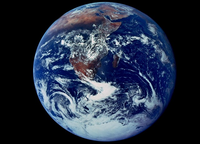

The image features a large, close-up view of the Earth from space. It is a beautifully detailed photo that captures the entire planet with its continents and oceans clearly visible. The Earth appears to be in daylight, making it an ideal time for observing the planet's natural beauty.


In [4]:
prompt = "Please describe concisely the content in the above figure."
result, image = await llm.query(prompt, "./figures/earth.jpg", slot_id=0)
display(image)
print(result["answer"].strip())

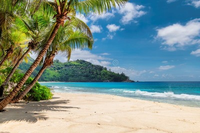

The image features a beautiful beach with white sand and palm trees. There are several people enjoying the sunny day, some of them closer to the water while others are further back on the shore. A few boats can be seen in the ocean, adding to the picturesque scene.


In [5]:
prompt = "Please describe concisely the content in the above figure."
result, image = await llm.query(prompt, "./figures/beach.jpg", slot_id=0)
display(image)
print(result["answer"].strip())

#### Update system prompt at runtime

In [6]:
system_prompt = {
    "system_prompt": {
    "prompt": (
        "You are a helpful language and vision assistant. "
        "You are able to understand the visual content that the user provides, "
        "and assist the user with a variety of tasks using natural language."
              ),
    "anti_prompt": "User",
    "assistant_name": "Assistant"
    }
}
await llm.update_system_prompt(system_prompt)

True

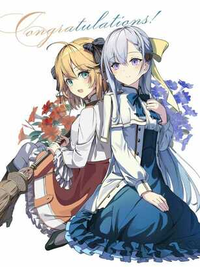

The image features two anime characters, a girl and a woman, sitting next to each other. They are both wearing dresses with the woman's dress being blue. Both of them have long hair, and they appear to be posing for a picture. There is also a broom in the scene, which could possibly be part of their outfit or used as an accessory.


In [7]:
prompt = "Please describe concisely the content in the above figure."
result, image = await llm.query(prompt, "./figures/girls.jpg", slot_id=0, seed=0)
display(image)
print(result["answer"].strip())


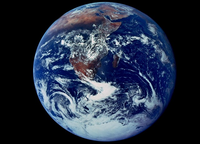

A blue and white globe,
A world of oceans and land.
The continents are visible,
And the atmosphere is vast.
The moon is a small speck in space,
Orbiting around our planet's place.
This image captures Earth's beauty,
In all its intricate glory.


In [8]:
prompt = "Please write a short poem based on the content in the above figure."
result, image = await llm.query(prompt, "./figures/earth.jpg", slot_id=0, seed=0)
display(image)
print(result["answer"].strip())


#### Batch evaluation

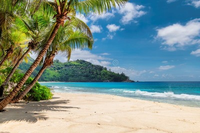

The image depicts a beautiful beach scene with palm trees and blue water. There are several people enjoying the sunny day at the beach, some standing near the water's edge and others further away. A few boats can be seen in the distance, adding to the picturesque atmosphere of the scene.


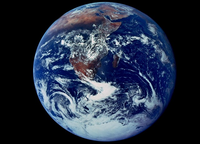

The image is a close-up of the Earth, showing its surface and oceans. It appears to be taken from space, giving an aerial view of the planet.


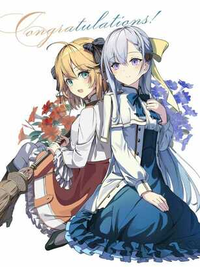

The image features two anime characters, a girl and a woman, sitting together. They are both wearing dresses, with one of the women having her arm around the other. Both of them have long hair, and they appear to be posing for a picture. In addition to their outfits, there is a broom in the scene, which could indicate that they might be witches or related to some magical theme.


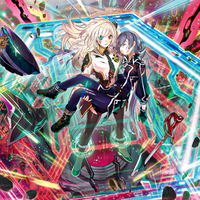

The image features two female characters in a futuristic setting, with one woman holding the other on her back. They are both dressed in black and white outfits, which gives them an air of sophistication. In addition to these two main characters, there is another person visible in the background, standing near the edge of the image. The scene appears to be set against a backdrop of futuristic elements such as a chair and a clock.


In [9]:
images = [f.as_posix() for f in Path("figures/").glob("*.jpg")]
prompts = ["Please describe concisely the content in the above figure."] * len(images)
results, images = await llm.batch_query(prompts,images)
for image, result in zip(images, results):
    answer = result["answer"].strip()
    display(image)
    print(answer)

#### Some dumb questions without figures.

In [10]:
prompts = [
    "How to build a website?",
    "Teach me how to calculate $\pi$?"
]
results, _ = await llm.batch_query(prompts)
for prompt, result in zip(prompts, results):
    answer = result["answer"].strip()
    print(f"Q: {prompt}\nA: {answer}")
    print("-"*20)

Q: How to build a website?
A: Building a website involves several steps, which are outlined below:

1. Choose a domain name and register it: A unique and memorable domain name is essential for your website. You can register a domain name through a domain registrar like GoDaddy or Namecheap.
2. Select a web hosting provider: Your web host will provide the server space where your website files will be stored. Popular web hosts include Bluehost, HostGator, and SiteGround.
3. Choose a website builder or CMS: There are various website builders available like Wix, Squarespace, WordPress, and Shopify that allow you to create a website without coding knowledge. Alternatively, if you prefer to have full control over your website's code, you can use a Content Management System (CMS) like WordPress or Drupal.
4. Design the layout: Decide on the overall look and feel of your website. You can hire a designer or use free templates available online.
5. Develop the content: Write engaging and informat

In [11]:
llm.stop_server()

-15

In [12]:
!nvidia-smi

Wed Nov  1 22:09:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 55%   66C    P0    73W / 250W |     17MiB / 11016MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 50%   